In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,precision_recall_curve
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,Lasso
from sklearn.preprocessing import OneHotEncoder,StandardScaler,MinMaxScaler,Binarizer
from sklearn.model_selection import cross_val_score,GridSearchCV

In [3]:
df = pd.read_csv('./not_encoding.csv', encoding="utf-8-sig",index_col=0)

In [37]:
df.head()

,category,amt,gender,is_fraud,distance,age,recency,city_pop_category,trans_hour_category,trans_month_category,region
0,misc_net,4.97,F,0,48.838332,31,0.0,소도시,night,상반기,south
1,grocery_pos,107.23,F,0,18.773002,41,0.0,소도시,night,상반기,west
2,entertainment,220.11,M,0,67.236235,57,0.0,소도시,night,상반기,west
3,gas_transport,45.00,M,0,59.448672,52,0.0,소도시,night,상반기,west
4,misc_pos,41.96,M,0,48.191593,33,0.0,소도시,night,상반기,south


In [4]:
col = ['region','trans_month_category','trans_hour_category','city_pop_category','gender','category']
df_dummy = pd.get_dummies(df[col])
df.drop(col,axis=1,inplace=True, errors='ignore')
df = pd.concat([df,df_dummy],axis=1)
mapping = {'trans_category_기타': '기타거래','trans_category_온라인거래':'온라인거래','trans_category_오프라인거래':'오프라인거래','trans_month_category_상반기':'상반기','trans_month_category_하반기':'하반기','trans_hour_category_day':'주간','trans_hour_category_night':'야간','city_pop_category_대도시':'대도시','city_pop_category_중소도시':'중소도시','city_pop_category_소도시':'소도시','gender_F':'남성','gender_M':'여성','amt':'거래량','distance':'카드거래발생거리','age':'실소유자나이','recency':'카드거래간시간','region_mid_west':'중서부','region_north_east':'북동부','region_south':'남부','region_west':'서부','is_fraud':'이상거래'}
df.rename(columns = mapping,inplace=True) 


In [6]:
df.columns

Index(['거래량', '이상거래', '카드거래발생거리', '실소유자나이', '카드거래간시간', '중서부', '북동부', '남부',
       '서부', '상반기', '하반기', '주간', '야간', '대도시', '소도시', '중소도시', '남성', '여성',
       'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')

### 불균형데이터 처리


In [5]:
# 오버샘플링 데이터
x = df.drop(['이상거래'],axis=1)
y = df['이상거래']

oversample =SMOTE(sampling_strategy=0.1,random_state=1,n_jobs=-1)
x_over, y_over = oversample.fit_resample(x, y)


In [29]:
print(x_over.shape)
print(y_over.shape)

(1418085, 31)
(1418085,)


In [6]:
# 언더샘플링 데이터

undersample = RandomUnderSampler(sampling_strategy='majority',random_state=1)
x_under, y_under = undersample.fit_resample(x_over, y_over)


In [7]:
print(x_under.shape)
print(y_under.shape)

df_under = pd.concat([x_under,y_under],axis=1)

(257832, 31)
(257832,)


In [8]:
df_under['이상거래'].value_counts()

0    128916
1    128916
Name: 이상거래, dtype: int64

### 이상치제거
- 이상거래를 예측하는 모델에서 이상값을 제거하지 않은 데이터 피팅이 더 예측력이 높을 것 같다는 설정을함 
- 즉, 이상치를 제거하지 않음

# scaling

KeyboardInterrupt: 

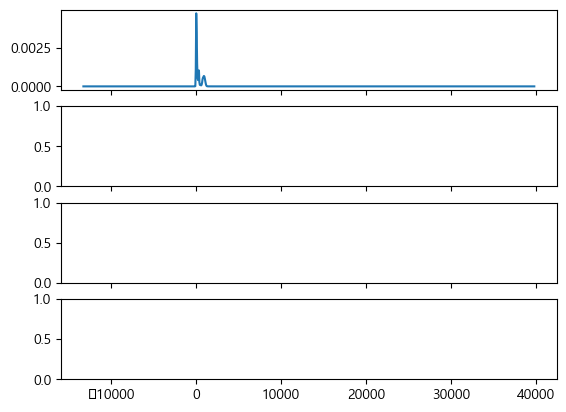

In [9]:
##  수치형 변수만 스케일링 minmax할지 표준화 할지 데이터의 분포 확인필요
numeric_columns = ['거래량','카드거래발생거리','실소유자나이','카드거래간시간']

plt.rc('font',family='Malgun Gothic')
x_under[numeric_columns].plot(kind='kde',subplots=True)

## 분포를 확인해 보았을때  
## 거래량,카드거래간시간 변수는 minmax
## 카드거래발생거리, 실소유자나이는 standard

In [10]:
##
#  나이, 거리 '카드거래간시간', '거래량StandardScaler

x= x_under[[ '카드거래발생거리','실소유자나이','카드거래간시간', '거래량']]

# StandardScaler객체 생성
scaler = StandardScaler()
# StandardScaler 로 데이터 셋 변환. fit() 과 transform() 호출.  
scaler.fit(x)
x_scaled = scaler.transform(x)

x_under[[ '카드거래발생거리','실소유자나이','카드거래간시간', '거래량']] = pd.DataFrame(x_scaled)
x_under[[ '카드거래발생거리','실소유자나이','카드거래간시간', '거래량']]

print('카드거래발생거리의 평균', x_under['카드거래발생거리'].mean())
print('카드거래발생거리의 분산', x_under['카드거래발생거리'].var())

print('실소유자나이의 평균', x_under['실소유자나이'].mean())
print('실소유자나이의 분산', x_under['실소유자나이'].var())

print('카드거래간시간의 평균', x_under['카드거래간시간'].mean())
print('카드거래간시간의 분산', x_under['카드거래간시간'].var())

print('거래량의 평균', x_under['거래량'].mean())
print('거래량의 분산', x_under['거래량'].var())

x_under[[ '카드거래발생거리','실소유자나이','카드거래간시간', '거래량']] = pd.DataFrame(x_scaled)

카드거래발생거리의 평균 4.524742718123193e-16
카드거래발생거리의 분산 1.0000038785095382
실소유자나이의 평균 5.4619982729379e-16
실소유자나이의 분산 1.0000038785099992
카드거래간시간의 평균 -2.1044852023598653e-15
카드거래간시간의 분산 1.0000038785095486
거래량의 평균 8.602003964385402e-15
거래량의 분산 1.0000038785095628


In [11]:
# test 데이터 스케일링
test = pd.read_csv('./yet_test.csv',encoding='UTF-8-sig')
x = test[['카드거래발생거리','실소유자나이','카드거래간시간', '거래량']]
x_scaled = scaler.transform(x)
test[['카드거래발생거리','실소유자나이','카드거래간시간', '거래량']] = pd.DataFrame(x_scaled)

test.to_csv('test_final.csv',encoding='UTF-8-sig')

FileNotFoundError: [Errno 2] No such file or directory: './yet_test.csv'

In [74]:
## 전처리 완료후 전체 데이터프레임

complete_df = pd.concat([x_under,y_under],axis=1)

In [66]:
complete_df.to_csv('train_final_2.csv',encoding='UTF-8-sig')

###  스케일링 후 변수간에 상관관계 확인

<AxesSubplot:>

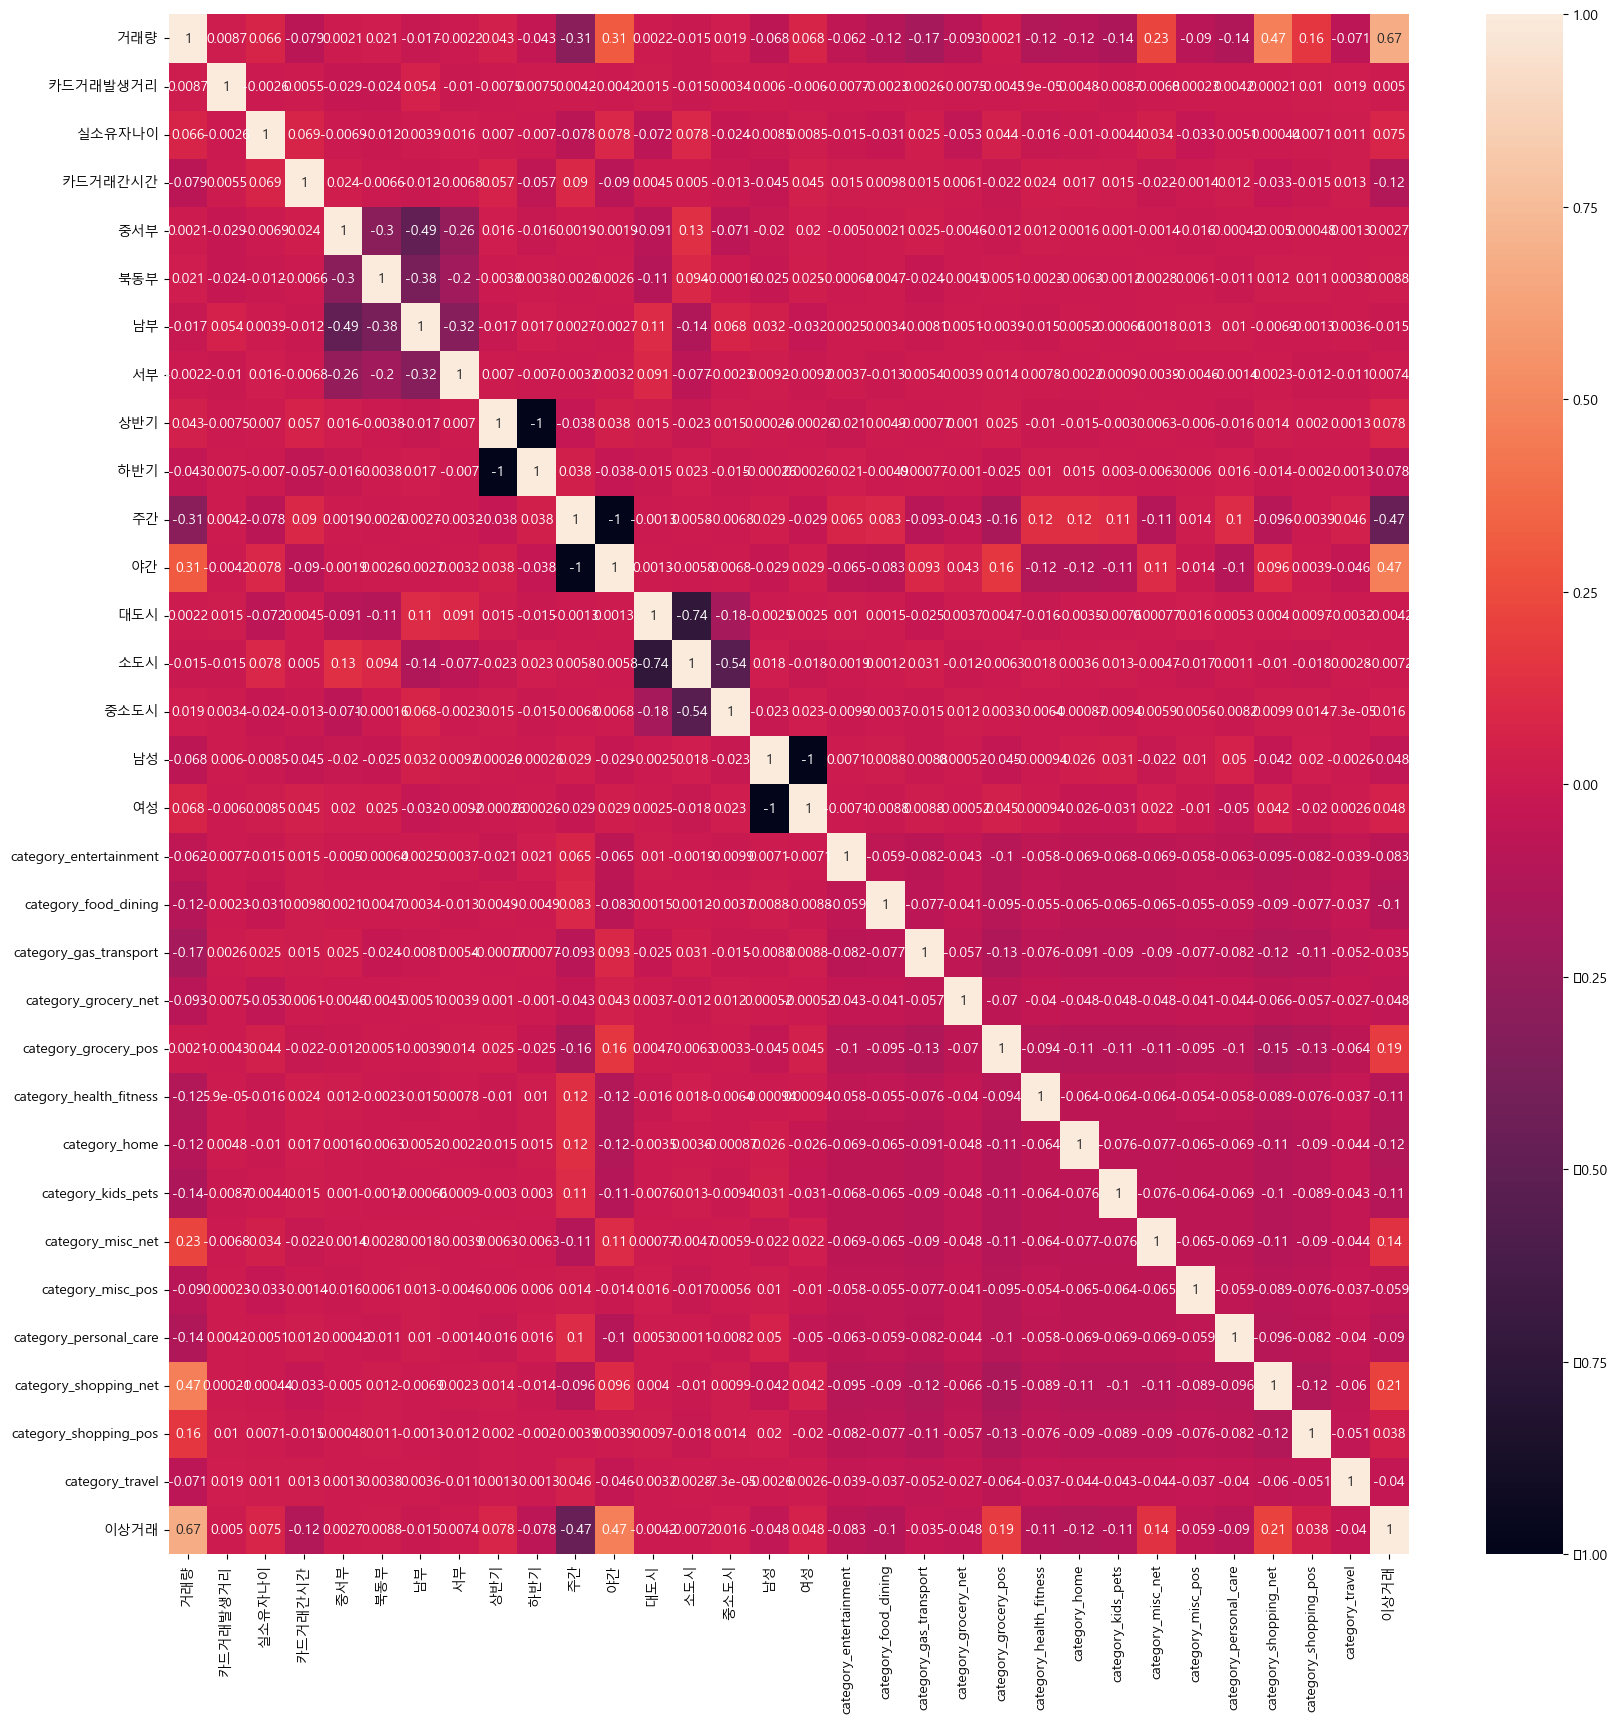

In [40]:
plt.figure(figsize=(20,20))
plt.rc('font',family='Malgun Gothic')
sns.heatmap(complete_df.corr(),annot=True)

# feature_selection

In [76]:
## 랜덤포레스트에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 feature_importance 변수 선택
rf = RandomForestClassifier(random_state=1)
param = {
    'max_depth':[2,3,4,5],
    'min_samples_split' : [1,2,3],
    'min_samples_leaf' : [1,2]
}

grid_rf = GridSearchCV(rf,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_rf.fit(x_under,y_under)

scores_df = pd.DataFrame(grid_rf.cv_results_)
scores_df.iloc[:,4:]

best_rf = grid_rf.best_estimator_  # 최적의 하이퍼파라미터를 적합한 모델
print(best_rf.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=5, min_samples_split=1, random_state=1)>


In [ ]:
### 랜덤포레스트 
### 최적의 하이퍼파라미터{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 1}

best_rf.fit(x_under,y_under)
importance= pd.Series(index=x_under.columns,data=best_rf.feature_importances_)
ft_im = importance.sort_values(ascending=False)
print(ft_im)

score = cross_val_score(best_rf,X=x_under,y=y_under,cv=5,scoring='accuracy')
print(f'교차검증 평균 정확도 : {np.mean(score)}')

#plt.figure(figsize=(8,6))
plt.title("Feature importances ")
sns.barplot(x=ft_im,y=ft_im.index)
plt.show()


## 시각화를 통핟여 선정된 피쳐
## ['거래량',주간','카드거래간시간','하반기','중서부','남부','서부','북동부''cetegory']

In [ ]:
## 로지스틱 라쏘규제에서 최적의 하이퍼 파라미터를 찾아서 
## 적합후 coefficients를 통하여 변수 선택(0은 설명력 부족한 변수)
lr=LogisticRegression(random_state=1,penalty='l1',solver='liblinear')
param = {'C':[0.005,0.01,0.05,0.1,1,2]}

grid_lr = GridSearchCV(lr,param_grid=param,cv=5,refit=True,scoring='accuracy')
grid_lr.fit(x_under,y_under)

scores_df = pd.DataFrame(grid_lr.cv_results_)
print(scores_df.iloc[:,4:])

best_lr = grid_lr.best_estimator_  # 최적의 하이퍼파라미터를 적합한 모델

In [ ]:
### 로지스틱 라쏘
### 최적의하이퍼파라미터 0.05
la =LogisticRegression(random_state=1,penalty='l1',solver='liblinear',C=0.05)

la.fit(x_under,y_under)
la_col = pd.Series(la.coef_[0],index=x_under.columns).sort_values(ascending=False)
print(la_col)

plt.title("Feature coefficient")
sns.barplot(x=la_col,y=la_col.index)
plt.show()

## 시각화를 통핟여 선정된 피쳐
#['거래량',주간','카드거래간시간','하반기','중서부','남부','서부','북동부','cetegory']

- 피쳐 선택결과 유사한 변수선택됨 
- 최종 features selection
- colums = ['거래량','주간,'카드거래간시간','대도시','중소도시',소도시','실소유자나이','하반기','중서부','남부','서부','북동부']
- 주간이면 1 야간이면 0인 컬럼
- 하반기면 1 상반기면 0인 컬럼

In [14]:
x_selec = x_under[['거래량','주간','카드거래간시간','하반기','category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel','중서부','남부','서부','북동부','대도시','중소도시','소도시']]

x_selec.head()

,거래량,주간,카드거래간시간,하반기,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,...,category_shopping_net,category_shopping_pos,category_travel,중서부,남부,서부,북동부,대도시,중소도시,소도시
0,-0.726008,0,1.327249,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
1,-0.748638,0,-0.546514,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,-0.740962,1,2.468824,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.581060,0,-0.553466,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,-0.468711,1,-0.258119,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [15]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_feature(x_train):
    vif = pd.DataFrame()
    vif['VIF_factor'] = [variance_inflation_factor(x_train.values,i) for i in range(x_train.shape[1])]
    vif['feature'] = x_train.columns
    return vif
    
vif =vif_feature(x_selec)
vif

,VIF_factor,feature
0,1.525943,거래량
1,2.259969,주간
2,1.025825,카드거래간시간
3,1.716410,하반기
4,1.311066,category_entertainment
5,1.307292,category_food_dining
6,1.415167,category_gas_transport
7,1.148969,category_grocery_net
8,1.439180,category_grocery_pos
9,1.307853,category_health_fitness
